# Analytics Snippet: Natural Language Processing Text Classification

According to an article written by [IBM](https://www.ibm.com/blogs/watson/2016/05/biggest-data-challenges-might-not-even-know/), it is estimated at 80% of all data is unstructured. Unstructured data is the messy stuff every quantitative analyst tries to traditionally stay away from. It can include images of accidents, text notes of loss adjusters, social media comments, claim documents and review of medical doctors etc. How can actuaries make use of these kinds of data to add value to the insurer and what techinques are available for handling these types of data? <br>
In the insurance industry, text data appears everywhere but is generally more prevalent in the marketing, sales and claims. Listed below are some of the possible areas in which an insurer can benefit from text data analytics: <br>
* **General Insurance**
 * Sentiment analysis from customer feedback
 * Chatbots for product recommendations and customer service
 * Automation of claims management process
* **Life Insurance**
 * Increase accuracy of underwriting process with the use of context analysis from social media platforms
 * Improved customer service through timely responses on coverage, billing ect. especially with the massive library of PDSes
* **Investments**
 * Recommendation systems based on risk appetite identification from client conversations


In this article, we are going to be looking at one of the topics within Natural Language Processing: Text Classification. The way we are going to handle this problem can be split into 3 distinct parts:
1. Importing and cleaning the dataset 
2. Transforming text to numbers
3. Classifying the complaints using supervised learning techniques

### Tools and Packages

The article uses [Python](https://www.python.org/) and the main packages that we will be using are listed below:
* [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/) for general data manipulation
* [Matplotlib](https://matplotlib.org/) and [Seaborn](https://seaborn.pydata.org/) for general data visualisation
* [Sci-kit](http://scikit-learn.org/stable/) learn packages for both feature extraction and classification model

In [1]:
import pandas as pd
import fastparquet
import numpy as np
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## Importing and Cleaning Data

The dataset we are using here consists of information regarding finance related complaints that a particular company has received from its customers.
It is provided by an open source data library managed by the U.S. General Services Administration and can be downloaded [here](https://catalog.data.gov/dataset/consumer-complaint-database). However, the binder does not require the reader to download the dataset in order to run the models, and the reader is encouraged to play around with the code, use a different classification model to get more accurate results!
<br> 
Since we are trying to predict the category of products based on the  complaints received, we can ignore the rest of the columns for the purposes of this exercise and only look at 2 of them, in particular:
* Description - Narrative of customer's complaint
* Product - The category of financial products which the complaint relates to
<br>

We will also get rid of null entries as they will not be of any use to us.

In [2]:
url = 'https://www.dropbox.com/s/9whncsovtccbgx8/Consumer_complaints.parquet?dl=1'
df = pd.read_parquet(url)
df = df.loc[(df['Consumer complaint narrative'].notnull()), ['Consumer complaint narrative', 'Product']] \
       .reset_index() \
       .drop('index', axis = 1)
df = df[(np.logical_not(df.Product.str.contains(','))) & (df.Product != 'Credit card or prepaid card')]
df.columns = ['description', 'target']
pd.set_option('display.max_colwidth', 250)
df.head()

,description,target
0,I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements,Credit reporting
1,"I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had ta...",Consumer Loan
2,"An account on my credit report has a mistaken date. I mailed in a debt validation letter to allow XXXX to correct the information. I received a letter in the mail, stating that Experian received my correspondence and found it to be "" suspicious '...",Credit reporting
3,This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine.,Debt collection
4,"This complaint is in regards to Square Two Financial. Refer to CFPB case number XXXX regarding CACH, L. L. C. Square Two Financial has utilized my entire social security number to include date of birth on the pfd document listed with this complai...",Debt collection


Next, we will assign each target variable an integer value instead of using the string representation (Credit reporting for example). This allows our models to be able to recognize the responses. We can do this using a variety of methods, but here we will be using sklearn's LabelEncoder function.

In [3]:
encoder = LabelEncoder()
encoder.fit(df.target)
df = df.assign(encoded_response = lambda x: encoder.transform(x.target))
df[['target', 'encoded_response']].drop_duplicates() \
                                  .set_index('target') \
                                  .sort_values('encoded_response', ascending = True)

,encoded_response
target,
Bank account or service,0
Checking or savings account,1
Consumer Loan,2
Credit card,3
Credit reporting,4
Debt collection,5
Money transfers,6
Mortgage,7
Other financial service,8


We can see from the output above, that our resulting dataset contains 14 unique categories which we will try to classify complaints into by training our model to "understand" the narrative. <br>
After encoding our target variable, we can then move on to splitting our dataset for training and validation purposes. Train test splits are a crucial part of any modelling process and prevents [overfitting](https://en.wikipedia.org/wiki/Overfitting). Here, we are using an 80/20 split and setting a random seed for the purpose of reproducibility.

In [4]:
x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(df.description, 
                                                                                 df.encoded_response,
                                                                                 df.index,
                                                                                 test_size = 0.2, 
                                                                                 random_state = 1)

## Feature Extraction

Just as we have encoded our target variables, we must also find a way to transform our description data out if its string representation into a numerical one. However, unlike the target variables, this process is not as simple as allocating an integer value to each unique complaint. Keep in mind that a meaningful transformation must somehow display some form of homogeneity between complaints within the same product categories.

### Bag of Words (BOW) Model

One way of transforming a document full of text data into numerical features is by using the BOW (Bag of Words) model. Put simply, all it does is assign each unique word (or token) an ID number and counts up its frequency. For example, if we have a document: <br><br>
`"This is a cat. That is a dog"`
<br><br>
The BOW representation would simply be: <br><br>
`BOW = {"This": 1, "is": 2, "a": 2, "cat" : 1, "That" : 1, "dog" : 1}`
<br><br>
Notice that the document shown above is clearly about a cat and a dog. However, our BOW model shows that the most frequent words present in the document are "is" and "a". These common words are also known as ["stop words"](https://en.wikipedia.org/wiki/Stop_words) and are usually filtered out of the BOW model during the pre-processing phase to prevent overpowering the words that have actual importance. There are many different little tricks and techniques for choosing the most suitable bag of words to represent your documents and most can be implemented simply through a line (or two) of code using [regular expressions](https://docs.python.org/2/library/re.html), which is a great way to filter texts and I highly recommend getting comfortable with using them.<br>
How does this link back to the goal of having numerical features as our inputs? Imagine having a thousand text documents and extracting all (a subset) of the unique tokens that we think best represents them. Now, we can assign each unique token to a column in a dataframe and populate the rows with each document’s count of the respective words. Following the example above, our single document would produce a dataframe that looks like: <br><br>

In [5]:
pd.DataFrame({"This": 1, "is": 2, "a": 2, "cat" : 1,
              "That" : 1, "dog" : 1}, index = range(1))

,This,is,a,cat,That,dog
0,1,2,2,1,1,1


Realistically, if we had chosen 15,000 unique tokens from the 1000 documents, our input matrix would then have 15,000 columns! You can start to imagine how sparse (full of zeros) our resulting input matrix will be! This technique is also commonly known as count vectorizing. <br>
In this article however, we will be using a more robust model compared to count vectorizing called (TF-IDF) Term Frequency - Inverse Document Frequency, and it is defined as:

$w_{i,j} = tf_{i,j} * log(\dfrac{N}{df_i})$ 
<br><br>
$w_{i,j}$ = Weight for word(i) in document(j) <br>
$tf_{i,j}$ = Count of word(i) in document(j) <br>
$N$ = Total number of documents <br>
$df_i$ = How many documents word(i) appears in<br><br>

We can see that, the first term of the TF-IDF model is just the count of the word in the document as before. The magic happens in the second term where the model imposes an additional condition for a particular word to be deemed "important". Just as an example, if the word "bank" appears in every single document, it wouldn't be of much use in differentiating the documents, and the second term of the TF-IDF model expresses this by reducing the whole weight down to 0. For a more detailed explanation on how TF-IDF works, there is an article written at [elephate.com](https://www.elephate.com/blog/what-is-tf-idf/) explaining it quite elegantly.

There are a variety of packages that help to automate the vectorizing process, but we have chosen to use the Sci-kit learn API due to its easy of usage and interpretability. Here, we instantiate a TfidfVectorizer model, with a few note-worthy details: <br>
* Sublinear_tf uses a logarithmic form of frequency as 20 occurrences of a word does not imply 20 times the importance in most cases <br>
* The model will ignore words that appear in less than 5 documents, as well as more than 70% of the total documents <br>
* Normalization is set to L2 (Not to be confused with L2 regularisation) so that all vectors are scaled to have a magnitude of 1 (The equivalent of standardizing your features) <br>
* There is a layer of pre-processing to remove numerical characters and symbols within the documents through the use of a regular expression (REGEX)

In [6]:
tfidf_vectorizer = TfidfVectorizer(sublinear_tf = True, 
                                   stop_words = 'english',
                                   min_df = 5,
                                   max_df = 0.7,
                                   norm = 'l2',
                                   token_pattern = r'\b[^_\d\W]+\b')

We then use the model to fit our original description data, and convert all that sweet text information into something numerical!

In [7]:
tfidf_train = tfidf_vectorizer.fit_transform(x_train.values)
tfidf_test = tfidf_vectorizer.transform(x_test.values)

In [8]:
print(len(tfidf_vectorizer.get_feature_names()))

19285


We can see that our resulting dictionary consists of 19,285 different unqiue words!

In [9]:
tfidf_df = pd.DataFrame(tfidf_train.A, 
                        columns = tfidf_vectorizer.get_feature_names())

In [10]:
tfidf_df.head()

,aa,aaa,aaddress,aadvantage,aafes,aag,aand,aargon,aarp,ab,...,zeroed,zfn,zions,zip,zombie,zone,zoned,zones,zoning,zwicker
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As mentioned above, the 19,285 words chosen to be in our "dictionary" become the columns of our input matrix and just to reiterate, since we have so many columns and each row only consists of words within 1 document, the resulting matrix will be extremely sparse! (Consisting mostly of zeros) <br>
Now that we have extracted some numerical features from our dataset, it is time to use them to train a classifier!

## Logistic Regression Classifier

In this example, we have chosen to use a basic [logistic regression model](http://www.appstate.edu/~whiteheadjc/service/logit/intro.htm) to classify the documents due to tractability and convention. However, more complex models such as neural networks, decision trees, naive bayesian classifiers or other relevant models can also be used to do the following classification and the reader is encouraged to try different machine learning models to see which ones give the most accurate results!<br>
Firstly, we instantiate a logistic regression classifier from the sklearn package and proceed to fit our TF-IDF vectorized matrix and our encoded training labels.

In [11]:
lr_classifier = LogisticRegression()
lr_classifier.fit(tfidf_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We can observe that amongst the model parameters, sklearn has automatically set 'penalty' to L2. This is a form of regularization, which weighs the benefits of a better fit against using more features by adding an extra term to the objective function. Coursera does quite a good job in explaining what L2 regularization in logisitic regression means [here](https://www.coursera.org/lecture/ml-classification/l2-regularized-logistic-regression-DBTNt). Recall that when using the BOW model, we ended up creating thousands of features. Adding regularization to our model would then help to prevent creating too many of them!

In [12]:
coefficients = pd.DataFrame(dict(zip(tfidf_df.columns,lr_classifier.coef_[0])),index = [0]).T.reset_index()
coefficients.columns = ['features', 'coefficients']
coefficients.head(10)

,features,coefficients
0,aa,-0.064147
1,aaa,-0.422178
2,aaddress,-0.019091
3,aadvantage,0.808570
4,aafes,-0.143279
5,aag,-0.051489
6,aand,-0.063603
7,aargon,-0.150654
8,aarp,-0.069611
9,ab,-0.261654


Since we have converted all our 'text' data into numerical features, we can view the weights and features just as we would be able to for any other logisitic regression model on numerical data.

In [13]:
pred = lr_classifier.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print(score)

0.8517154487303741


After running the model on the validation set, we can see that we attained some pretty decent results with an overall accuracy of 85.2% with just a simple logistic regression classifier. We can drill down into this result by evaluating the [confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology).

In [14]:
cm = metrics.confusion_matrix(y_test, pred)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

Due to the huge imbalance of data points between the different categories, the resulting figures in the confusion matrix are normalized to produce clearer distinctions between “good” and “poor” performance.

Text(0.5,1,'Accuracy Score: 0.8517154487303741')

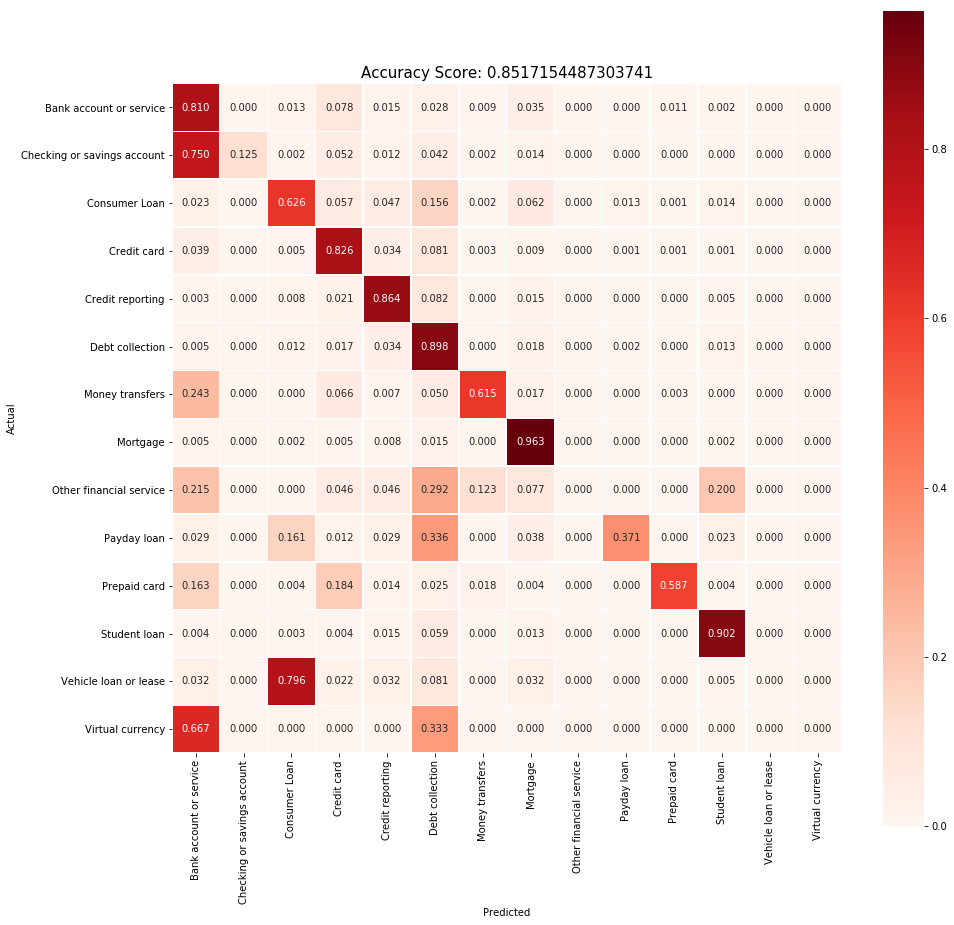

In [15]:
plt.figure(figsize = (15,15))
sns.heatmap(cm, 
            annot = True, 
            fmt = ".3f", 
            linewidths = 0.5, 
            square = True, 
            cmap = 'Reds', 
            xticklabels = encoder.classes_,
            yticklabels = encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
all_sample_title = 'Accuracy Score: {}'.format(score)
plt.title(all_sample_title, size = 15)

One of the more obvious results we can observe just from diagonals of the matrix is that "Other financial service", "Vehicle loan or lease" and "Virtual currency" categories had no correct predictions. We must note however, that the number of data points we had for each of these categories were insignificant compared to the others and the model probably treated those instances as errors instead of a distinct category. This bias however, can be corrected by techniques such as [over and undersampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis). Let's investigate further to see if the model does indeed treat the documents within these categories as errors.

In [16]:
def report2dict(cr):
    '''Function solely for formatting purposes, can be ignored'''
    
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    measures = tmp[0]
    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return D_class_data

In [17]:
results = metrics.classification_report(y_test, pred,
                                    target_names = encoder.classes_)
pd.DataFrame(report2dict(results)).transpose()

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,f1-score,precision,recall,support
Bank account or service,0.78,0.76,0.81,2965.0
Checking or savings account,0.22,0.98,0.12,424.0
Consumer Loan,0.67,0.73,0.63,1884.0
Credit card,0.81,0.80,0.83,3696.0
Credit reporting,0.87,0.88,0.86,6240.0
Debt collection,0.87,0.84,0.90,9600.0
Money transfers,0.68,0.76,0.61,301.0
Mortgage,0.94,0.92,0.96,7359.0
Other financial service,0.00,0.00,0.00,65.0
Payday loan,0.49,0.71,0.37,342.0


We can see that calling the classification_report function actually produces a _UndefinedMetricWarning_ but what does this mean? <br>
If we look deeper into this, the error actually tells us that the model, made no predictions (correctly or incorrectly) for those 3 categories, which supports the hypothesis we made earlier that these documents were just treated as errors! Since we can roughly pinpoint the reasons for misclassifications in these 3 categories, let's try to look at a category where data points were not sparse and try to find an explanation for those misclassified documents. <br>
Shown below are some examples where 'Checking and savings account' narratives were wrongly classified as 'Bank account and service'.

Categories with more data points generally had a better score, and the reasons for misclassifications in these categories seem to follow the trend of overlapping categories. (For example, 320 descriptions that were supposed to be "Checking and savings account" related were wrongly classified as "Bank account and service".

In [18]:
def observe_errors(actual_response, wrongly_predicted_response):
    warnings.filterwarnings(action = 'ignore', category = DeprecationWarning)
    compare = pd.DataFrame(list(zip(x_test, y_test, pred)), columns = ['description', 'actual', 'predicted'])
    compare = compare.assign(actual_product = encoder.inverse_transform(compare.actual),
                             predicted_product = encoder.inverse_transform(compare.predicted)) \
                     .loc[(compare.actual == actual_response) & (compare.predicted == wrongly_predicted_response),
                         ['description', 'actual_product', 'predicted_product']]
    return compare

In [19]:
observe_errors(actual_response = 1, wrongly_predicted_response = 0).tail(5)

,description,actual_product,predicted_product
35632,"On Saturday morning around XXXX XXXX , I went to the Chase Bank # XXXX on XXXX XXXX XXXX XXXX in XXXX , Texas to try to open an savings account. I was received by the Teller I asked her nicely that I wanted to open an savings acco...",Checking or savings account,Bank account or service
35748,PNC bank changed the terms on my bank account a second time without notifying me. The first change would prevent me from ever having a transaction in the bank with a human being without being charged a fee. I learned about this issue after findin...,Checking or savings account,Bank account or service
35835,"On XXXX XXXX , 2017 , I deposited several checks into my checking account, one of which was in excess of {$5000.00}. The branch manager put a hold on this check thereby making these funds unavailable to me for the purpose to which they were i...",Checking or savings account,Bank account or service
35870,"I did a complaint to Bank of America, because XXXX charge withdraw money from my account, one year ago my daughter call XXXX for do a question, but we decided do not use XXXX because a Mistake the company withdraw money from my bank account...",Checking or savings account,Bank account or service
36085,"I opened a PMA checking and brokerage account with Wells Fargo in XXXX . I had XXXX checking account, a credit card and ATM card at that time. At some point in XXXX , inexplicably, a second checking account appeared on my statements. ...",Checking or savings account,Bank account or service


We can see that the misclassified complaints shown above is quite ambiguous and contain ideas and keywords within the narrative related to both categories, which is presumably why the model would have misclassified them.

Because of the how text data is converted into numerical features, data pre-processing is an extremely important step when it comes to NLP problems and the "garbage-in, garbage-out" property can be very prevalent compared to other machine learning techniques. Also note that, in this problem that there are existing labels in the dataset, and we could have just as easily used any other supervised learning techniques to classify the documents. If however, no labels are available, we would then have to turn towards unsupervised learning algorithms such as SVM, K-means or LDA to try and cluster the documents into sensible categories.

## Afterward

We have essentially just taught the computer how to "understand" a small selected group of documents in a very human way, which is just amazing! So, you might ask, how does this apply to actuarial work? <br>
Imagine having access to all the historical claim narratives within your company's database. What do you think are some possible projects that will add value to your insurer now that you know how to model text? Could you maybe come up with a classifier using techniques above coupled with some clustering analysis techniques such as K-Means to categorize the claims if the legacy system does not have this feature? What about doing some sentiment analysis on the claim narratives to get the general satisfaction level of customers and to help pinpoint the strengths and weaknesses of the insurer's current claims handling process? <br>
Do not be mistaken though, the possibilities are not constrained to the claims management section of the insurance value chain. Other examples include chatbots and recommendation systems as distribution channels, and fraud detection with text analysis. The possibilities are endless and it is up to the actuarial profession to keep up with the trends in order to continue adding value to the industry.

## Further Analysis

If you would like to further explore the capabilities of different BOW and classification models using this dataset, [Kaggle](https://www.kaggle.com/sebastienverpile/consumercomplaintsdata/home) provides an outlet to publish your results and discuss them with others!